<br>

<br>

# This next cell contains methods for generating data for training the feature extractor and data for environments 1, 2, and 3 by adding color to the MNIST images and binarizing the image labels.

In [1]:

import numpy as np
import struct
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd
import pandas as pd
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats



# Download and split MNIST data
mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:40000], mnist.targets[:40000])
mnist_test = (mnist.data[40000:], mnist.targets[40000:])
mnist_all = (mnist.data, mnist.targets)

#Shuffle the data
rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

rng_state = np.random.get_state()
np.random.shuffle(mnist_all[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_all[1].numpy())

# Splitting the data that will be used to train the feature extractor 
# into 80% train set and 20% test set
X_train = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train = mnist_all[1][:int(0.8*len(mnist_all[1]))] 
X_test = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test = mnist_all[1][int(0.8*len(mnist_all[1])):]


# used to binarize the target variable
def binarize(y, label_noise=0.):
    
    y = np.copy(y) > 4
    
    if label_noise > 0:
        y = np.logical_xor(y, np.random.binomial(1, label_noise, size=len(y)))
    
    return y.astype(int)

# used to randomly add color to the dataset used to train the feature extractor
def color_digits(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0    
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)



# used to color either the entire dataset green or the entire dataset red
def color_all_images_same_color(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
        
    if green:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.)


# Produce images for the factor model
def produce_images_for_the_factor_model(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    color = None    
    if green:
        color = np.ones(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        color = np.zeros(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)


# Used to generate environments 1, 2, and 3 by varying the distribution of color
def generate_environments(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0
    
    colored_X = colored_X.reshape(X.shape[0],-1)
    
    return {
      'images': (colored_X.astype(float) / 255.),
      'labels': y[:, None],
      'colors': color[:, None]
    }

    
    
# Used to plot colored images    
def plot_images(X, n_row=10, n_col=10, shape=(2,14,14), scale=False):
    fig = plt.figure(figsize=(n_row, n_col))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )
    for ax in grid:
        index = np.random.choice(np.arange(X.shape[0]))
        img = X[index].reshape(shape)
        if scale:
            img = img - img.min()
            img /= img.max()
        img = np.vstack((img, np.zeros((1,shape[1],shape[2]))))
        img = np.moveaxis(img, 0, -1)
        ax.imshow(img)
        ax.set_axis_off()
    plt.show()
    return

<br>

# Define, train, and evaluate the feature extractor

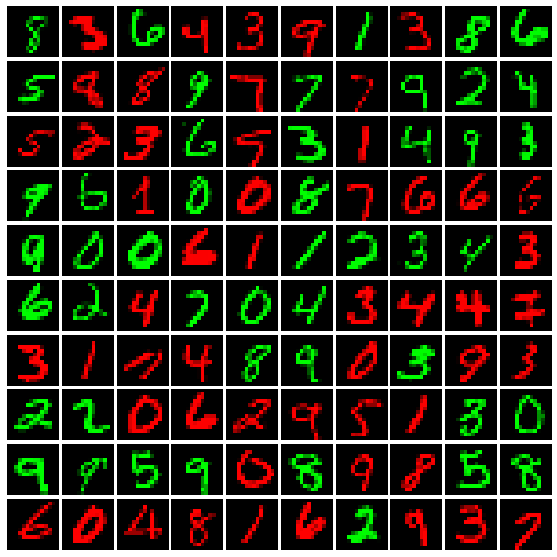

Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)
Label Accuracy:  0.9456666666666667
Color Accuracy:  1.0


In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

class MLP(torch.nn.Module):

    def __init__(self, size=[2*14*14, 2]):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(size)-2):
            layers.append(torch.nn.Linear(size[i], size[i+1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(size[-2], size[-1]))
        self.net = torch.nn.Sequential(*layers)
        print(self.net)

    def forward(self, x):
        return self.net(x)

def tensor_numpy(arrays, device):
    out = []
    for a in arrays:
        out.append(torch.from_numpy(a).float().to(device))
    return out
    
    
np.random.seed(1)
label_noise = 0.
color_noise = None

y_train = binarize(y_train, label_noise=label_noise)
y_test = binarize(y_test, label_noise=label_noise)

X_train, color_train = color_digits(X_train, y_train, color_noise, downsample=True)
X_test, color_test = color_digits(X_test, y_test, color_noise, downsample=True)

plot_images(X_train)
# plot_images(X_test)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

hidden_size = [2*14*14, 50, 2]
net = MLP(hidden_size).to(device)

tr_x, tr_y, tr_c = tensor_numpy([X_train, y_train, color_train], device)
te_x, te_y, te_c = tensor_numpy([X_test, y_test, color_test], device)

bs = 256

tr_dataset = TensorDataset(tr_x, tr_y, tr_c)
tr_loader = DataLoader(tr_dataset, batch_size = bs, shuffle = True)
# te_dataset = TensorDataset(te_x, te_y, te_c)
# te_loader = DataLoader(te_dataset, batch_size = bs, shuffle = True)

loss_label = torch.nn.BCEWithLogitsLoss()
loss_color = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

epoch = 10
for e in range(epoch):
    
    for x, y, c in tr_loader:
        
        optimizer.zero_grad()
        
        out = net(x)
        loss_y = loss_label(out[:,0], y)
        loss_c = loss_color(out[:,1], c)
        loss = loss_y + loss_c
        
        loss.backward()
        optimizer.step()
        
            
with torch.no_grad():
    test_preds = 1*(net(te_x).detach().cpu().numpy()>0)
#     acc_y = (test_preds[:,0] == y_test).mean()
#     acc_c = (test_preds[:,1] == color_test).mean()
    acc_y = accuracy_score(y_test, test_preds[:,0])
    acc_c = accuracy_score(color_test, test_preds[:,1])
    print('Label Accuracy: ', acc_y)
    print('Color Accuracy: ', acc_c)

<br>

# Use the trained feature extractor to extract features from data that will be used to train and test our classifiers

In [3]:
label_noise = 0.
color_noise = None


env1_X_train = mnist_train[0][::2]
env1_y_train = binarize(mnist_train[1][::2], label_noise=label_noise)

env2_X_train = mnist_train[0][1::2]
env2_y_train = binarize(mnist_train[1][1::2], label_noise=label_noise)

env3_X_train = mnist_test[0]
env3_y_train = binarize(mnist_test[1], label_noise=label_noise)

envs = [
generate_environments(env1_X_train, env1_y_train, 0.2),
generate_environments(env2_X_train, env2_y_train, 0.4),
generate_environments(env3_X_train, env3_y_train, 0.9)
]


class feature_extractor(nn.Module):
    def __init__(self):
        super().__init__()   
        net.eval()
        self.children_list = []
        for n,c in net.named_children():
            self.children_list.append(c)
            
        print("Printing all the trained model layers")
        print(self.children_list)
        self.children_list = self.children_list[0][:2]
        print("Printing model layers after dropping the output layer for feature extraction")    
        print(self.children_list)
        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x


def extract_features(model,x,y, device = 'cpu'):
    extracted_features = []
    labels = []   
    with torch.no_grad():
        x = x.to(device)
        extracted_features = model(x.float())
    extracted_features = torch.flatten(extracted_features, 1)
    extracted_features_df = pd.DataFrame(extracted_features.numpy())
    extracted_features_df["target"] = y.cpu().numpy()
    return extracted_features_df



train_envs_1_and_2_inputs = torch.cat((torch.from_numpy(envs[0]['images']), torch.from_numpy(envs[1]['images'])), 0)
train_envs_1_and_2_targets = torch.cat((torch.from_numpy(envs[0]['labels']), torch.from_numpy(envs[1]['labels'])), 0)

print("Combined environments 1 and 2 data size - used to train our final prediction models")
print(len(train_envs_1_and_2_inputs))
print(len(train_envs_1_and_2_targets))

test_inputs =torch.from_numpy(envs[2]['images'])
test_targets =torch.from_numpy(envs[2]['labels'])

print("Environment 3 data size - used to test our final prediction models")
print(len(test_inputs))
print(len(test_targets))

feature_extractor = feature_extractor()

train_extracted_features_df = extract_features(feature_extractor,train_envs_1_and_2_inputs, train_envs_1_and_2_targets)
test_extracted_features_df = extract_features(feature_extractor,test_inputs, test_targets)


print("Printing the extracted features - first train features followed by test features shape/size!!!")
# print(train_extracted_features_df)
print(train_extracted_features_df.shape)
# print(test_extracted_features_df)
print(test_extracted_features_df.shape)


Combined environments 1 and 2 data size - used to train our final prediction models
40000
40000
Environment 3 data size - used to test our final prediction models
20000
20000
Printing all the trained model layers
[Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)]
Printing model layers after dropping the output layer for feature extraction
Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
)
Printing the extracted features - first train features followed by test features shape/size!!!
(40000, 51)
(20000, 51)


<br>

<br>

# Transforming the extracted image features using a factor model

# Preparing the features that we will need to obtain F and L for.

All images colored green
Color labels for green:
[1 1 1 ... 1 1 1]


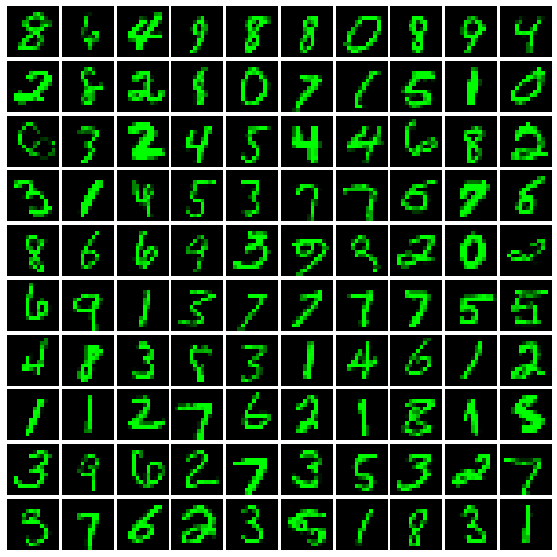

All images colored red
Color labels for red:
[0 0 0 ... 0 0 0]


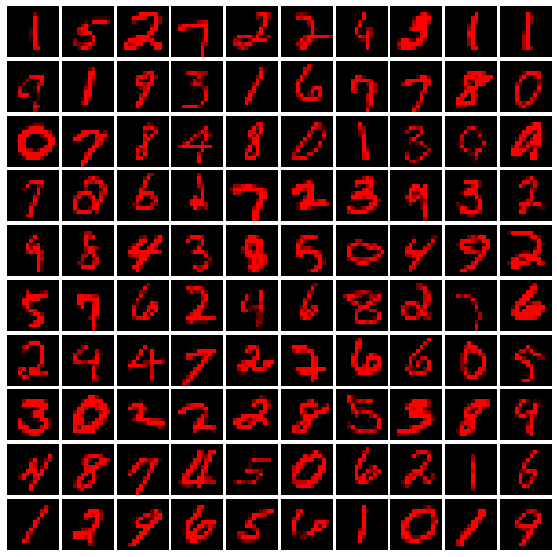

All images red and green combined so each image has a duplicate in opposite color
Color labels:
[1 1 1 ... 0 0 0]


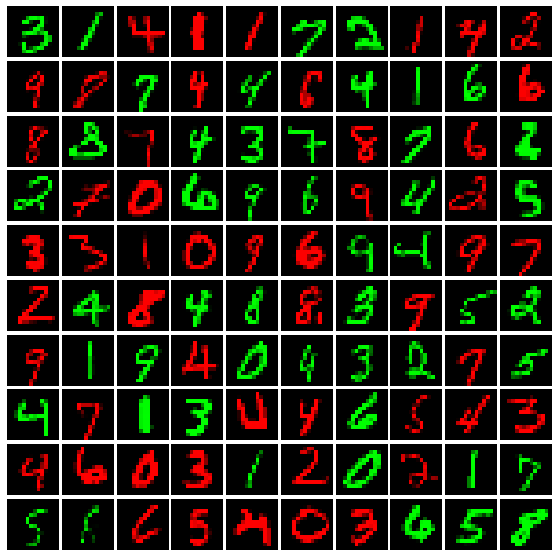

Green test images
Color labels for green test images:
[1 1 1 ... 1 1 1]


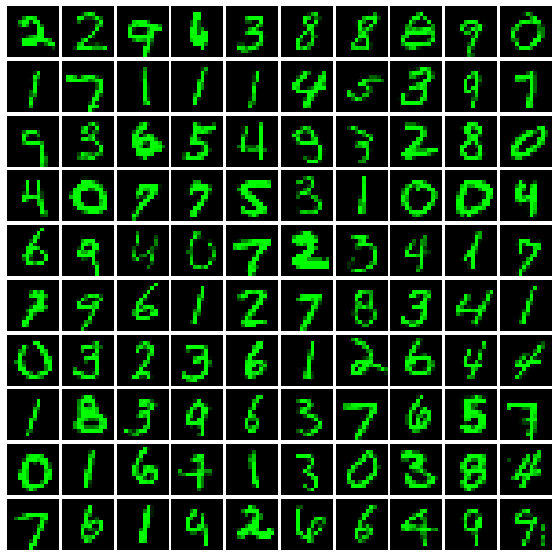

Red test images
Color labels for red test images:
[0 0 0 ... 0 0 0]


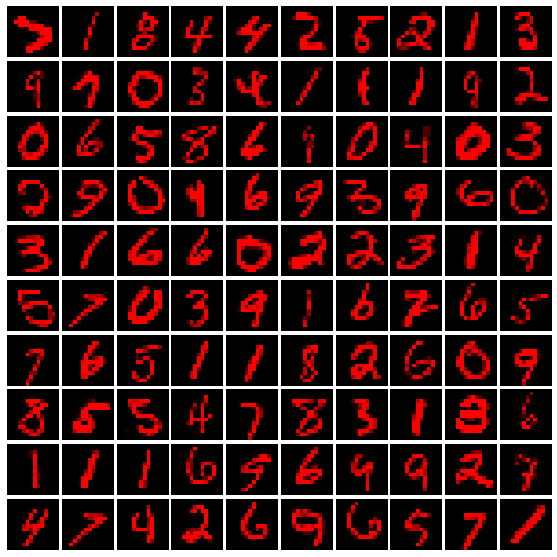

All test images red and green combined so each image has a duplicate in opposite color
Test color labels:
[1 1 1 ... 0 0 0]


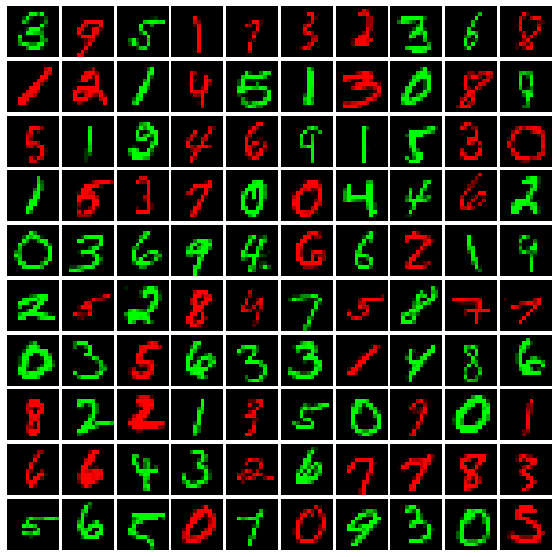

Z shape
(96000, 50)
Z_test shape
(24000, 50)
Z_test_green shape
(12000, 50)
Z_test_red shape
(12000, 50)


In [4]:
X_train_ = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train_ = mnist_all[1][:int(0.8*len(mnist_all[1]))]

X_test_ = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test_ = mnist_all[1][int(0.8*len(mnist_all[1])):]

y_train_ = binarize(y_train_, label_noise=label_noise)
y_test_ = binarize(y_test_, label_noise=label_noise)

green_images, color_green = produce_images_for_the_factor_model(X_train_, green=True)

red_images, color_red = produce_images_for_the_factor_model(X_train_, green=False)

green_and_red_images = np.concatenate((green_images, red_images), axis=0)
color = np.concatenate((color_green, color_red), axis=None)
label_train = np.concatenate((y_train_, y_train_), axis=None)


green_images_test, color_green_test = produce_images_for_the_factor_model(X_test_, green=True)

red_images_test, color_red_test = produce_images_for_the_factor_model(X_test_, green=False)

green_and_red_images_test = np.concatenate((green_images_test, red_images_test), axis=0)
color_test = np.concatenate((color_green_test, color_red_test), axis=None)
label_test = np.concatenate((y_test_, y_test_), axis=None)



print("All images colored green")
print("Color labels for green:")
print(color_green)
plot_images(green_images)


print("All images colored red")
print("Color labels for red:")
print(color_red)
plot_images(red_images)

print("All images red and green combined so each image has a duplicate in opposite color")
print("Color labels:")
print(color)
plot_images(green_and_red_images)



print("Green test images")
print("Color labels for green test images:")
print(color_green_test)
plot_images(green_images_test)


print("Red test images")
print("Color labels for red test images:")
print(color_red_test)
plot_images(red_images_test)

print("All test images red and green combined so each image has a duplicate in opposite color")
print("Test color labels:")
print(color_test)
plot_images(green_and_red_images_test)






# extract features from green and red train images
Z = extract_features(feature_extractor,torch.from_numpy(green_and_red_images), 
                                        torch.from_numpy(color)).to_numpy()[:, :-1]

# extract features from green and red test images
Z_test = extract_features(feature_extractor,torch.from_numpy(green_and_red_images_test), 
                                        torch.from_numpy(color_test)).to_numpy()[:, :-1]


# extract features from green test images
Z_test_green = extract_features(feature_extractor,torch.from_numpy(green_images_test), 
                                        torch.from_numpy(color_green_test)).to_numpy()[:, :-1]

# extract features from red test images
Z_test_red = extract_features(feature_extractor,torch.from_numpy(red_images_test), 
                                        torch.from_numpy(color_red_test)).to_numpy()[:, :-1]

# Features from images in environments 1, 2, and 3. Environments 1 and 2 are combined to be used for training. 
Z_envs_1_and_2 = train_extracted_features_df.to_numpy()[:, :-1]
Z_env3 = test_extracted_features_df.to_numpy()[:, :-1]


print("Z shape")
print(Z.shape)

print("Z_test shape")
print(Z_test.shape)

print("Z_test_green shape")
print(Z_test_green.shape)

print("Z_test_red shape")
print(Z_test_red.shape)




# Training the factor model to obtain F and L.

In [5]:
import torch
from torch.autograd import Variable

dtype = torch.FloatTensor
n = Z.shape[0]
d = Z.shape[1]
k = int(Z.shape[1]*0.2) # 20% of original number of features

F1 = Variable(torch.randn(n,1).type(dtype), requires_grad=False)
F1[color.astype(bool)] = -1
F1[~color.astype(bool)] = 1
print("Shape of F1")
print(F1.shape)

# F2 = torch.nn.Parameter(data=torch.randn(n, k-1).type(dtype), requires_grad=True)
F2 = Variable(torch.randn(n, k-1).type(dtype), requires_grad=True)

print("Shape of F2")
print(F2.shape)


F = torch.cat((F1, F2), 1)
print()
print()
print("Shape of initial F")
print(F.shape)
print("Printing initial F")
print(F)

L = Variable(torch.randn(k, d).type(dtype), requires_grad=True)
# L = torch.nn.Parameter(data=torch.randn(k, d).type(dtype), requires_grad=True)

print()
print()
print("Shape of initial L")
print(L.shape)
print("Print initial L")
print(L)
print()
print()

# Zero out the diagonal of the matrix
def get_off_diagonal_elements(M):
    res = M.clone()
    res.diagonal(dim1=-1, dim2=-2).zero_()
    return res




optimizer = torch.optim.Adam([F2, L], lr=0.01)

for epoch in range(30000):        
    optimizer.zero_grad() 
    F = torch.cat((F1, F2), 1)
#     reconstruction_loss = torch.square(torch.linalg.matrix_norm(torch.sub(torch.from_numpy(Z), torch.matmul(F, L)))) 
    reconstruction_loss = torch.sum(torch.square(torch.from_numpy(Z)-torch.matmul(F, L)))
    cov_F_off_diagonals_sum = torch.sum(torch.abs(get_off_diagonal_elements(torch.cov(F.T))))
    loss = reconstruction_loss + cov_F_off_diagonals_sum
    if epoch % 10000 == 0: 
        print("reconstruction loss")
        print(reconstruction_loss)
        print("off-diag loss")
        print(cov_F_off_diagonals_sum)
    loss.backward()
    optimizer.step()
    
    
    
print()
print()
print("Final F shape")
print(F.shape)    
print("Printing final F")
print(F)
print()
print()
print("Final L shape")
print(L.shape)
print("Print final L")
print(L)

Shape of F1
torch.Size([96000, 1])
Shape of F2
torch.Size([96000, 9])


Shape of initial F
torch.Size([96000, 10])
Printing initial F
tensor([[-1.0000, -0.0449, -1.1646,  ...,  1.8692, -0.5058, -0.7865],
        [-1.0000,  0.4397,  0.5823,  ...,  1.3432, -0.0056,  1.2384],
        [-1.0000, -0.9317,  0.7498,  ..., -0.1883,  0.1113, -1.6392],
        ...,
        [ 1.0000, -0.3068, -0.0907,  ...,  0.4708,  0.5287,  0.6854],
        [ 1.0000,  1.1355,  0.4630,  ...,  0.2422, -1.1883,  0.7556],
        [ 1.0000,  1.2618, -1.3755,  ..., -1.1693,  1.0988,  0.8215]],
       grad_fn=<CatBackward0>)


Shape of initial L
torch.Size([10, 50])
Print initial L
tensor([[ 5.4754e-01,  2.3431e+00,  7.1839e-01, -1.1300e-01, -5.7797e-02,
         -3.1465e-01, -1.2984e+00,  1.5565e+00,  8.7746e-02,  1.3734e+00,
          6.7121e-01,  2.0577e+00,  9.8671e-01,  1.2856e+00, -3.4515e-01,
          4.4682e-01, -1.1074e+00,  2.6860e-01, -4.2354e-01,  1.5415e+00,
          2.1332e+00,  7.4945e-01, -3.0411e-01,

reconstruction loss
tensor(381609.9079, dtype=torch.float64, grad_fn=<SumBackward0>)
off-diag loss
tensor(12.8024, grad_fn=<SumBackward0>)
reconstruction loss
tensor(381573.8787, dtype=torch.float64, grad_fn=<SumBackward0>)
off-diag loss
tensor(11.0359, grad_fn=<SumBackward0>)


Final F shape
torch.Size([96000, 10])
Printing final F
tensor([[-1.0000,  0.2764, -0.3588,  ..., -0.2054, -0.0105,  0.2511],
        [-1.0000,  0.5888, -0.5725,  ...,  0.1090,  0.1613,  0.5206],
        [-1.0000, -0.1663, -0.7049,  ..., -0.4113,  1.0969,  0.4413],
        ...,
        [ 1.0000, -0.2177, -0.6876,  ...,  0.8105, -0.7880, -1.0693],
        [ 1.0000, -1.0267, -0.5408,  ...,  0.4078,  0.1974, -0.1713],
        [ 1.0000,  2.3752, -2.5711,  ...,  0.5903, -0.0225,  0.3126]],
       grad_fn=<CatBackward0>)


Final L shape
torch.Size([10, 50])
Print final L
tensor([[ 2.7097e-01,  1.7987e+00,  1.6857e+00,  8.4769e-01, -8.5790e-01,
         -5.5864e-01,  5.8658e-01,  2.9689e-01,  1.5834e+00,  1.2554e+00,
 

# Function for obtaining F_test values from extracted image features

In [6]:
def get_off_diagonal_elements(M):
    res = M.clone()
    res.diagonal(dim1=-1, dim2=-2).zero_()
    return res

def get_F_test(Z_test, F_id):
    n = Z_test.shape[0]
    d = Z_test.shape[1]
    k = int(Z_test.shape[1]*0.2)
    F_test = Variable(torch.randn(n, k).type(dtype), requires_grad=True)

    print("Shape of initial "+F_id)
    print(F_test.shape)

    print("Printing initial "+F_id)
    print(F_test)

    print("Printing the shape of L used")
    print(L.shape)
    print("Values of L ")
    print(L)


    optimizer = torch.optim.Adam([F_test], lr=0.01)

    for epoch in range(30000):        
        optimizer.zero_grad() 
    #     reconstruction_loss = torch.square(torch.linalg.matrix_norm(torch.sub(torch.from_numpy(Z), torch.matmul(F, L)))) 
        reconstruction_loss = torch.sum(torch.square(torch.from_numpy(Z_test)-torch.matmul(F_test, L)))
        loss = reconstruction_loss
        if epoch % 10000 == 0: 
            print("reconstruction loss")
            print(reconstruction_loss)
        loss.backward()
        optimizer.step()

    print()
    print()
    print("Final "+F_id+" shape")
    print(F_test.shape)    
    print("Printing final "+F_id)
    print(F_test)
    
    return F_test
    

In [7]:
F_test = get_F_test(Z_test, "F_test")
F_test_green = get_F_test(Z_test_green, "F_test_green")
F_test_red = get_F_test(Z_test_red,"F_test_red" )

F_envs_1_and_2 = get_F_test(Z_envs_1_and_2, "F_envs_1_and_2")
F_env3 = get_F_test(Z_env3, "F_env3")

# Z_envs_1_and_2 = train_extracted_features_df.to_numpy()[:, :-1]
# Z_env3 = test_extracted_features_df.to_numpy()[:, :-1]


print("F_test shape")
print(F_test.shape)

print("F_test_green shape")
print(F_test_green.shape)

print("F_test_red shape")
print(F_test_red.shape)



Shape of initial F_test
torch.Size([24000, 10])
Printing initial F_test
tensor([[ 1.0241, -0.7314,  0.1057,  ..., -2.0883, -0.8172, -0.6393],
        [ 2.6000, -1.1752, -1.0054,  ...,  1.5970, -0.7782,  0.2531],
        [ 0.7269,  0.1324, -0.4852,  ...,  0.0211, -0.2473, -0.9370],
        ...,
        [-0.0600, -0.5347, -0.9290,  ..., -0.0420, -0.0274,  1.4666],
        [-1.8910,  0.6533, -1.1335,  ...,  1.4480, -0.1597, -0.8672],
        [-2.1139, -1.6055,  0.7094,  ..., -0.9481, -0.4627, -0.1662]],
       requires_grad=True)
Printing the shape of L used
torch.Size([10, 50])
Values of L 
tensor([[ 2.7097e-01,  1.7987e+00,  1.6857e+00,  8.4769e-01, -8.5790e-01,
         -5.5864e-01,  5.8658e-01,  2.9689e-01,  1.5834e+00,  1.2554e+00,
         -8.4003e-01, -3.1900e-01,  3.7940e-01,  1.6162e+00, -3.2428e-01,
         -6.2198e-01, -9.0323e-01,  7.4793e-01, -5.5454e-01,  7.9005e-01,
          1.7785e+00,  1.3071e-01,  3.0185e-01,  1.2409e+00, -2.5116e-01,
         -1.1415e+00, -4.9338e-01,

reconstruction loss
tensor(87775.0910, dtype=torch.float64, grad_fn=<SumBackward0>)


Final F_test shape
torch.Size([24000, 10])
Printing final F_test
tensor([[-1.1945,  0.5106, -0.9024,  ...,  0.4377,  0.1060,  0.6493],
        [-0.2998, -0.9835, -1.3007,  ...,  0.1848,  2.1131,  0.9201],
        [-0.8273,  0.4646, -0.4491,  ...,  0.2270,  0.8431,  0.9798],
        ...,
        [ 1.0781,  0.0284, -1.1048,  ...,  0.3969, -1.1504, -0.7653],
        [ 0.9456,  0.0304, -0.7714,  ...,  0.6374, -1.0379, -0.6338],
        [ 0.2072,  0.1263, -1.2577,  ..., -0.5223, -0.8563, -1.0308]],
       requires_grad=True)
Shape of initial F_test_green
torch.Size([12000, 10])
Printing initial F_test_green
tensor([[ 1.7878, -1.1857, -0.6947,  ...,  0.0256,  0.4646,  0.6148],
        [ 0.0272, -1.7691, -0.2126,  ...,  0.0055, -1.6644,  1.2985],
        [-0.9333,  0.2762, -0.4690,  ..., -0.4196, -2.6806,  0.1622],
        ...,
        [ 0.0863,  0.8906, -0.8071,  ..., -2.0408, -2.6951, -0.3113],
        [-1

reconstruction loss
tensor(33881.7024, dtype=torch.float64, grad_fn=<SumBackward0>)
reconstruction loss
tensor(33882.4068, dtype=torch.float64, grad_fn=<SumBackward0>)


Final F_test_green shape
torch.Size([12000, 10])
Printing final F_test_green
tensor([[-1.1944,  0.5107, -0.9026,  ...,  0.4379,  0.1062,  0.6493],
        [-0.2997, -0.9834, -1.3008,  ...,  0.1849,  2.1132,  0.9202],
        [-0.8273,  0.4646, -0.4492,  ...,  0.2270,  0.8432,  0.9798],
        ...,
        [-0.6195, -0.5300, -1.5638,  ...,  1.2119,  0.9216,  0.4855],
        [-0.6555, -0.5719, -1.6083,  ...,  0.7435,  1.0163,  0.0482],
        [-1.1177,  0.0043, -0.8728,  ...,  0.0536,  0.7422,  0.1689]],
       requires_grad=True)
Shape of initial F_test_red
torch.Size([12000, 10])
Printing initial F_test_red
tensor([[-0.5055,  0.5182,  2.6745,  ..., -0.0592,  0.3066, -0.7282],
        [-0.2761, -0.5351,  1.2672,  ..., -1.1958,  2.0541, -0.6922],
        [-0.3284, -1.6677,  0.4374,  ...,  1.4085, -0.2454, -0.3890],
  

reconstruction loss
tensor(53891.9199, dtype=torch.float64, grad_fn=<SumBackward0>)
reconstruction loss
tensor(53892.6188, dtype=torch.float64, grad_fn=<SumBackward0>)


Final F_test_red shape
torch.Size([12000, 10])
Printing final F_test_red
tensor([[ 0.8707, -0.9511, -0.1042,  ...,  0.0600, -0.6201, -0.2739],
        [ 2.2251,  0.8126, -0.5496,  ...,  1.7967, -0.4379,  1.4827],
        [ 0.6290,  1.3252, -1.8483,  ...,  0.0494,  0.0160,  0.1304],
        ...,
        [ 1.0781,  0.0285, -1.1049,  ...,  0.3969, -1.1504, -0.7653],
        [ 0.9456,  0.0304, -0.7714,  ...,  0.6374, -1.0379, -0.6338],
        [ 0.2085,  0.1277, -1.2591,  ..., -0.5215, -0.8549, -1.0295]],
       requires_grad=True)
Shape of initial F_envs_1_and_2
torch.Size([40000, 10])
Printing initial F_envs_1_and_2
tensor([[ 0.0571, -0.5739,  1.0238,  ...,  0.7062, -0.1709,  0.0080],
        [-0.3975,  1.1882, -0.6328,  ...,  0.1750, -0.7450,  1.9202],
        [-1.3056, -0.8918, -0.2403,  ...,  1.6184, -1.6406, -0.3495]

reconstruction loss
tensor(145865.3254, dtype=torch.float64, grad_fn=<SumBackward0>)
reconstruction loss
tensor(145867.6770, dtype=torch.float64, grad_fn=<SumBackward0>)


Final F_envs_1_and_2 shape
torch.Size([40000, 10])
Printing final F_envs_1_and_2
tensor([[ 1.4088, -0.8162,  0.5485,  ...,  0.8919,  0.0908,  1.0374],
        [-0.4313, -0.3804, -0.7921,  ...,  0.1010,  1.2624,  0.6814],
        [ 1.3918, -0.4944, -0.9932,  ...,  0.4867, -0.3224,  0.0386],
        ...,
        [-1.0423, -0.1349, -1.1308,  ...,  0.7175,  0.3388,  0.4888],
        [-1.6091,  0.2522, -1.5726,  ...,  0.2959,  1.0167,  0.4064],
        [ 0.5812, -0.0666, -0.3025,  ...,  0.5835, -0.3839, -0.1771]],
       requires_grad=True)
Shape of initial F_env3
torch.Size([20000, 10])
Printing initial F_env3
tensor([[ 0.8446,  0.3164,  0.2640,  ..., -0.6747,  0.7581,  0.4917],
        [ 0.6180,  0.1273,  0.5946,  ..., -1.3088,  0.1353, -0.4432],
        [ 0.9189, -0.2363,  0.9649,  ..., -1.2168,  0.7756, -0.9298],
    

reconstruction loss
tensor(73789.0376, dtype=torch.float64, grad_fn=<SumBackward0>)
reconstruction loss
tensor(73790.2114, dtype=torch.float64, grad_fn=<SumBackward0>)


Final F_env3 shape
torch.Size([20000, 10])
Printing final F_env3
tensor([[-0.7691, -0.3435, -1.2618,  ...,  0.3221,  1.7720,  0.7151],
        [ 0.6218,  0.3849, -0.6664,  ...,  1.1109, -0.8865, -1.0398],
        [-0.1303, -0.1442,  0.4492,  ..., -1.5929,  0.4361, -0.4288],
        ...,
        [ 1.0781,  0.0285, -1.1048,  ...,  0.3969, -1.1504, -0.7653],
        [ 0.9457,  0.0304, -0.7715,  ...,  0.6376, -1.0379, -0.6338],
        [ 0.2072,  0.1264, -1.2577,  ..., -0.5224, -0.8562, -1.0307]],
       requires_grad=True)
F_test shape
torch.Size([24000, 10])
F_test_green shape
torch.Size([12000, 10])
F_test_red shape
torch.Size([12000, 10])


# Correlation Matrices

## Correlation Matrix for F

In [23]:
pd.DataFrame(torch.corrcoef(F.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.076856,0.260856,-0.158152,-0.000196,-0.057449,-0.561696,0.000212,-0.442075,-0.334429
1,-0.076856,1.000000,-0.119058,0.373110,-0.024707,-0.544134,-0.347061,0.320741,-0.207894,0.321755
2,0.260856,-0.119058,1.000000,-0.548278,-0.317770,0.243116,0.008315,-0.000096,-0.128767,0.333918
3,-0.158152,0.373110,-0.548278,1.000000,-0.158397,-0.000106,0.000010,0.615868,0.006493,-0.189716
4,-0.000196,-0.024707,-0.317770,-0.158397,1.000000,-0.619397,0.010555,-0.225903,-0.189394,0.110412
5,-0.057449,-0.544134,0.243116,-0.000106,-0.619397,1.000000,0.475089,-0.000054,-0.000162,-0.541791
6,-0.561696,-0.347061,0.008315,0.000010,0.010555,0.475089,1.000000,0.107550,-0.238771,-0.150372
7,0.000212,0.320741,-0.000096,0.615868,-0.225903,-0.000054,0.107550,1.000000,-0.248297,0.078105
8,-0.442075,-0.207894,-0.128767,0.006493,-0.189394,-0.000162,-0.238771,-0.248297,1.000000,0.363721
9,-0.334429,0.321755,0.333918,-0.189716,0.110412,-0.541791,-0.150372,0.078105,0.363721,1.000000


## Correlation Matrix for F_test

In [18]:
pd.DataFrame(torch.corrcoef(F_test.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.232506,0.166427,0.294159,-0.119416,-0.103299,-0.649580,0.381583,-0.256013,-0.068490
1,-0.232506,1.000000,-0.065175,-0.018986,0.049585,-0.470537,-0.165243,-0.040093,-0.273448,0.148791
2,0.166427,-0.065175,1.000000,-0.451144,-0.276456,0.246995,0.051469,-0.080097,-0.161030,0.260587
3,0.294159,-0.018986,-0.451144,1.000000,-0.270934,-0.072505,-0.296578,0.821593,0.173926,0.158340
4,-0.119416,0.049585,-0.276456,-0.270934,1.000000,-0.578627,0.099431,-0.321850,-0.223374,0.022278
5,-0.103299,-0.470537,0.246995,-0.072505,-0.578627,1.000000,0.472914,-0.068832,-0.020754,-0.540367
6,-0.649580,-0.165243,0.051469,-0.296578,0.099431,0.472914,1.000000,-0.225904,-0.295118,-0.277384
7,0.381583,-0.040093,-0.080097,0.821593,-0.321850,-0.068832,-0.225904,1.000000,-0.001581,0.317965
8,-0.256013,-0.273448,-0.161030,0.173926,-0.223373,-0.020754,-0.295118,-0.001581,1.000000,0.412608
9,-0.068490,0.148791,0.260587,0.158340,0.022278,-0.540367,-0.277384,0.317965,0.412608,1.000000


## Correlation Matrix for F_test_green

In [19]:
pd.DataFrame(torch.corrcoef(F_test_green.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.721715,-0.288499,0.859368,-0.408047,0.303446,-0.427699,0.504107,0.371374,-0.085284
1,-0.721715,1.000000,0.754460,-0.838297,0.590317,-0.408921,0.256761,-0.524324,-0.506854,0.343949
2,-0.288499,0.754460,1.000000,-0.665410,0.523252,-0.309390,0.191642,-0.528558,-0.535912,0.301191
3,0.859368,-0.838297,-0.665410,1.000000,-0.585262,0.499697,-0.241474,0.701154,0.371965,-0.304371
4,-0.408047,0.590317,0.523252,-0.585262,1.000000,-0.742957,0.108889,0.016394,-0.406237,0.389898
5,0.303446,-0.408921,-0.309390,0.499697,-0.742957,1.000000,0.260436,0.057720,-0.053277,-0.806606
6,-0.427699,0.256760,0.191642,-0.241474,0.108889,0.260436,1.000000,0.008034,-0.880167,-0.469498
7,0.504107,-0.524324,-0.528558,0.701154,0.016394,0.057720,0.008034,1.000000,0.016250,-0.040813
8,0.371374,-0.506854,-0.535912,0.371965,-0.406237,-0.053277,-0.880167,0.016250,1.000000,0.224708
9,-0.085284,0.343949,0.301191,-0.304371,0.389898,-0.806607,-0.469498,-0.040813,0.224708,1.000000


## Correlation Matrix for F_test_red

In [20]:
pd.DataFrame(torch.corrcoef(F_test_red.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.175799,-0.046144,0.689282,-0.145182,-0.305236,-0.524499,0.815022,0.153563,0.586286
1,-0.175799,1.000000,-0.316255,0.282379,-0.153084,-0.506285,-0.574887,0.112804,-0.270070,0.065771
2,-0.046144,-0.316255,1.000000,-0.366953,-0.551818,0.494864,0.266028,0.040172,0.500689,0.395539
3,0.689282,0.282379,-0.366953,1.000000,-0.154943,-0.331598,-0.556790,0.869765,-0.108438,0.280490
4,-0.145182,-0.153084,-0.551818,-0.154943,1.000000,-0.511406,0.126372,-0.429158,-0.162119,-0.100591
5,-0.305236,-0.506285,0.494864,-0.331598,-0.511406,1.000000,0.737792,-0.115722,-0.069963,-0.509439
6,-0.524499,-0.574887,0.266028,-0.556790,0.126372,0.737792,1.000000,-0.443280,-0.294027,-0.627295
7,0.815022,0.112804,0.040172,0.869765,-0.429158,-0.115722,-0.443280,1.000000,-0.023321,0.441619
8,0.153563,-0.270070,0.500689,-0.108438,-0.162119,-0.069963,-0.294027,-0.023321,1.000000,0.629643
9,0.586286,0.065771,0.395539,0.280490,-0.100591,-0.509439,-0.627295,0.441619,0.629643,1.000000


## Correlation Matrix for F_envs_1_and_2

In [21]:
pd.DataFrame(torch.corrcoef(F_envs_1_and_2.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.160678,0.243016,0.250301,-0.183865,-0.169290,-0.690395,0.330727,-0.193583,0.118620
1,-0.160678,1.000000,-0.181285,0.022769,0.164528,-0.592309,-0.272383,-0.047130,-0.342397,0.139794
2,0.243016,-0.181285,1.000000,-0.544909,-0.223336,0.240395,0.055028,-0.181193,-0.211839,0.253256
3,0.250301,0.022769,-0.544909,1.000000,-0.172689,-0.162919,-0.299026,0.821299,0.232759,0.205619
4,-0.183865,0.164528,-0.223336,-0.172689,1.000000,-0.576366,0.146690,-0.167075,-0.298730,0.098688
5,-0.169290,-0.592309,0.240395,-0.162919,-0.576366,1.000000,0.507127,-0.189274,0.125177,-0.567617
6,-0.690395,-0.272383,0.055028,-0.299026,0.146690,0.507127,1.000000,-0.204173,-0.224740,-0.321963
7,0.330727,-0.047130,-0.181193,0.821299,-0.167075,-0.189274,-0.204173,1.000000,0.051787,0.438997
8,-0.193583,-0.342397,-0.211839,0.232759,-0.298730,0.125177,-0.224740,0.051787,1.000000,0.246035
9,0.118620,0.139794,0.253256,0.205619,0.098688,-0.567617,-0.321963,0.438997,0.246035,1.000000


## Correlation Matrix for F_env3

In [22]:
pd.DataFrame(torch.corrcoef(F_env3.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.436239,-0.046628,0.442611,-0.009088,0.044443,-0.571410,0.503788,-0.341290,-0.399144
1,-0.436239,1.000000,0.235117,-0.142426,-0.155683,-0.133250,0.120424,-0.047667,-0.142432,0.153314
2,-0.046628,0.235117,1.000000,-0.114363,-0.458613,0.360770,0.089028,0.178410,-0.055038,0.253012
3,0.442611,-0.142426,-0.114363,1.000000,-0.469242,0.146422,-0.325652,0.852205,0.058991,0.110110
4,-0.009088,-0.155683,-0.458613,-0.469242,1.000000,-0.610200,0.018429,-0.568158,-0.137923,-0.118291
5,0.044443,-0.133250,0.360770,0.146422,-0.610200,1.000000,0.388108,0.217573,-0.296035,-0.459383
6,-0.571410,0.120424,0.089028,-0.325652,0.018429,0.388108,1.000000,-0.271545,-0.431525,-0.179943
7,0.503788,-0.047667,0.178410,0.852205,-0.568158,0.217573,-0.271545,1.000000,-0.109995,0.098285
8,-0.341290,-0.142432,-0.055038,0.058991,-0.137923,-0.296035,-0.431525,-0.109995,1.000000,0.664343
9,-0.399144,0.153314,0.253012,0.110110,-0.118291,-0.459383,-0.179943,0.098285,0.664343,1.000000


# Histograms

Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,2.065080,1.461838,0.798363,0.896535,0.306077,0.449171,0.454867,0.377902,0.726245,0.923241
1,2.524828,1.796083,0.751226,0.815036,0.017346,0.673632,1.096702,1.611785,2.551123,0.562484
2,1.456347,0.860566,1.399167,0.831409,0.276094,0.817022,1.314300,0.177645,0.827172,0.849407
3,1.815122,0.205508,1.425579,1.432853,0.400139,0.223930,0.991090,0.499215,1.066868,0.619313
4,2.034195,1.260600,1.496887,0.990912,0.083228,0.153558,0.476158,0.203398,0.891493,0.415629


Histogram for F Test feature  0


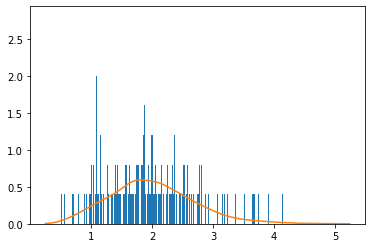

Histogram for F Test feature  1


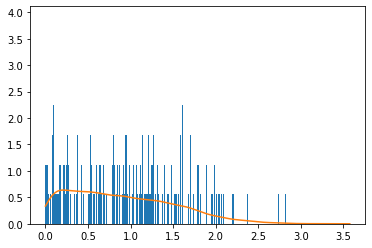

Histogram for F Test feature  2


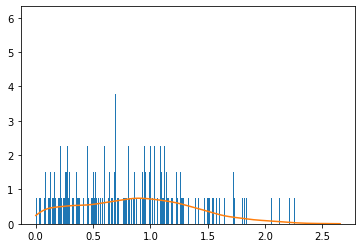

Histogram for F Test feature  3


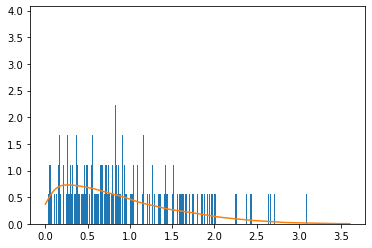

Histogram for F Test feature  4


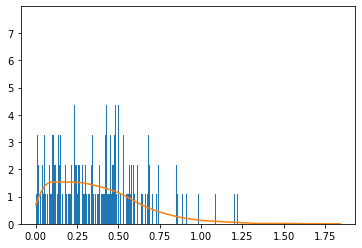

Histogram for F Test feature  5


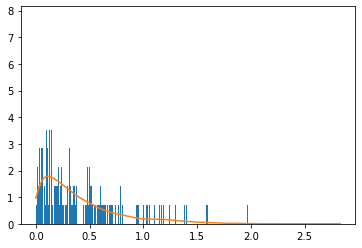

Histogram for F Test feature  6


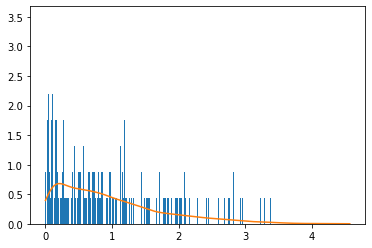

Histogram for F Test feature  7


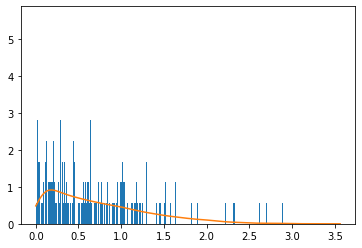

Histogram for F Test feature  8


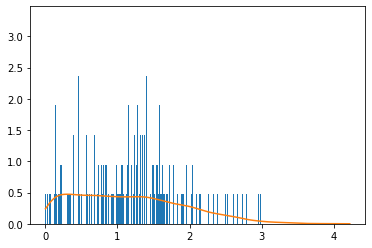

Histogram for F Test feature  9


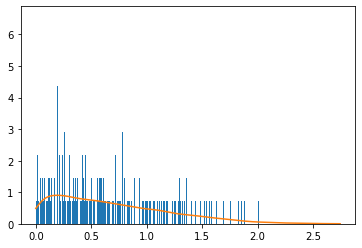

In [8]:
# the difference between F_test_green and F_test_red
delta_matrix = np.absolute(F_test_green.detach().numpy() - F_test_red.detach().numpy())

print("Printing the delta matrix")
delta_matrix_df = pd.DataFrame(delta_matrix)
display(delta_matrix_df.head())

# Plotting the histograms for each feature in the delta matrix # 24000 bins
for i in range(len(delta_matrix_df.columns)): 
    print("Histogram for F Test feature ", i)    
    feature = delta_matrix_df.iloc[:,i].values
    density = stats.gaussian_kde(feature)
    n, x, _ = plt.hist(feature, bins=np.linspace(np.amin(delta_matrix_df.iloc[:,i]), np.amax(delta_matrix_df.iloc[:,i]), 24000), 
                       histtype='bar', density=True)  
    plt.plot(x, density(x))
    plt.show()

Histogram for F Test feature  0


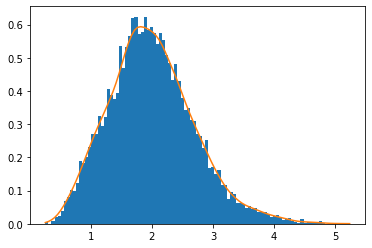

Histogram for F Test feature  1


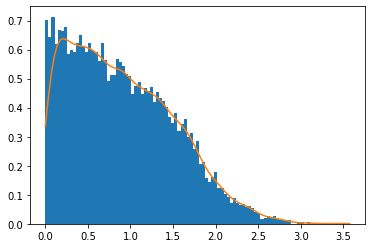

Histogram for F Test feature  2


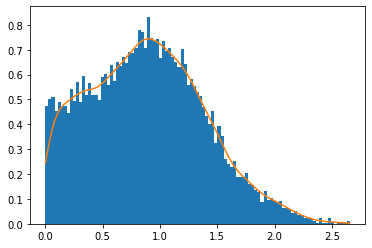

Histogram for F Test feature  3


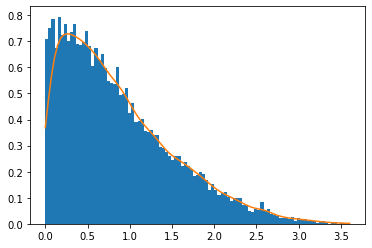

Histogram for F Test feature  4


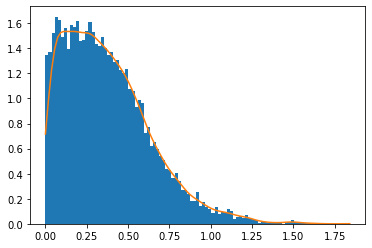

Histogram for F Test feature  5


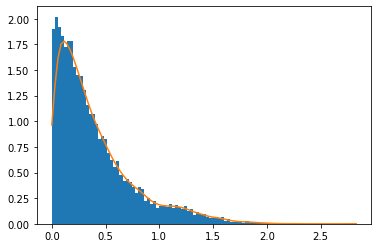

Histogram for F Test feature  6


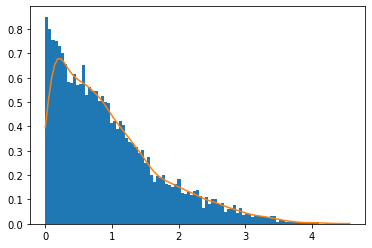

Histogram for F Test feature  7


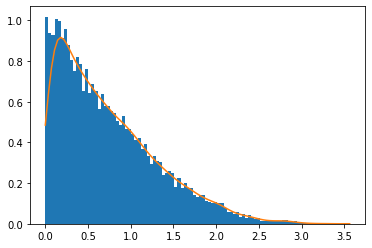

Histogram for F Test feature  8


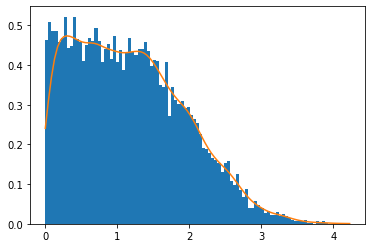

Histogram for F Test feature  9


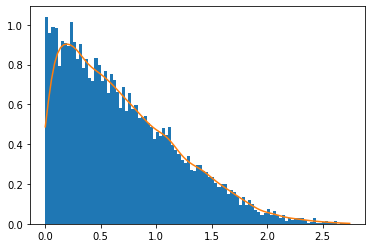

In [9]:
# Plotting the histograms for each feature in the delta matrix # 100 bins
for i in range(len(delta_matrix_df.columns)): 
    print("Histogram for F Test feature ", i)    
    feature = delta_matrix_df.iloc[:,i].values
    density = stats.gaussian_kde(feature)
    n, x, _ = plt.hist(feature, bins=np.linspace(np.amin(delta_matrix_df.iloc[:,i]), np.amax(delta_matrix_df.iloc[:,i]), 100), 
                       histtype='bar', density=True)  
    plt.plot(x, density(x))
    plt.show()


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features including color - Environment Shift Present - Logistic Regression

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from numpy import vstack
from numpy import sqrt

# train_data_path = './data/mnist_train_extracted_features.csv'
# test_data_path = './data/mnist_test_extracted_features.csv'

train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df

# #***** Obtaining the within training environment test data
# train, within_test = train_test_split(train_data_path, test_size=0.5, random_state=100)


def read_data(path):
#     data_df = pd.read_csv(path).to_numpy()
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch




class LogisticRegression(torch.nn.Module):
    def __init__(self, d):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(d,1)

    def forward(self, x):
        y_hat = self.linear(x)
        return torch.sigmoid(y_hat)

    
   
    
# train the model
def train_model(inputs, targets, model):
    # define the optimization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    
    for epoch in range(10000):        
        optimizer.zero_grad() 
        y_hat = model(inputs.float())
        loss = criterion(y_hat.float(), targets.float())
        loss.backward()
        optimizer.step()
      
        

# evaluate the model
def model_eval(inputs, targets, model):
    predictions, actuals = list(), list()
    yhat = model.forward(inputs.float())
    yhat = np.where(yhat.detach().numpy() < 0.5, 0, 1)
    actual = targets.detach().cpu().numpy()
    actual = actual.reshape((len(actual), 1))
    yhat = yhat.reshape((len(yhat), 1))

    predictions.append(yhat)
    actuals.append(actual)

    predictions, actuals = vstack(predictions), vstack(actuals)
#     calculate accuracy
    acc = accuracy_score(actuals, predictions)
#     acc = accuracy_score(actual, yhat)
    return acc


_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)
# X_torch_test_within, targets_torch_test_within = read_data(within_test)


X_torch_train = F_envs_1_and_2
X_torch_test = F_env3
X_torch_test_within = F_envs_1_and_2

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)

d = X_torch_train.shape[1]

print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)

model = LogisticRegression(d) 

train_model(X_torch_train, targets_torch_train, model)
accuracy = model_eval(X_torch_test, targets_torch_test, model)
accuracy_within = model_eval(X_torch_test_within, targets_torch_test_within, model)

print('Plain Logistic Regression Accuracy within training data: ',accuracy_within.round(4))
print('Plain Logistic Regression Accuracy on test data: ', accuracy.round(4))



# accuracy_list = []
# within_accuracy_list = []
# print("Mean accuracies after 10 runs:")
# for i in range(10):
#     train_model(X_torch_train, targets_torch_train, model)
#     accuracy = model_eval(X_torch_test, targets_torch_test, model)
#     accuracy_within = model_eval(X_torch_test_within, targets_torch_test_within, model)
#     accuracy_list.append(accuracy)
#     within_accuracy_list.append(accuracy_within)
# print()
# print('Plain Logistic Regression Mean Accuracy within training env: ', np.mean(within_accuracy_list).round(4), 
#       'std: ', np.std(within_accuracy_list).round(3))
# print('Plain Logistic Regression Mean Accuracy on env 3: ', np.mean(accuracy_list).round(4), 'std: ', 
#       np.std(accuracy_list).round(3))


Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])
Plain Logistic Regression Accuracy within training data:  0.9463
Plain Logistic Regression Accuracy on test data:  0.9018


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 Features Except color - Environment Shift Present - Logistic Regression

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from numpy import vstack
from numpy import sqrt

# train_data_path = './data/mnist_train_extracted_features.csv'
# test_data_path = './data/mnist_test_extracted_features.csv'

train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df

# #***** Obtaining the within training environment test data
# train, within_test = train_test_split(train_data_path, test_size=0.5, random_state=100)


def read_data(path):
#     data_df = pd.read_csv(path).to_numpy()
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch




class LogisticRegression(torch.nn.Module):
    def __init__(self, d):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(d,1)

    def forward(self, x):
        y_hat = self.linear(x)
        return torch.sigmoid(y_hat)

    
   
    
# train the model
def train_model(inputs, targets, model):
    # define the optimization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    
    for epoch in range(10000):        
        optimizer.zero_grad() 
        y_hat = model(inputs.float())
        loss = criterion(y_hat.float(), targets.float())
        loss.backward()
        optimizer.step()
      
        

# evaluate the model
def model_eval(inputs, targets, model):
    predictions, actuals = list(), list()
    yhat = model.forward(inputs.float())
    yhat = np.where(yhat.detach().numpy() < 0.5, 0, 1)
    actual = targets.detach().cpu().numpy()
    actual = actual.reshape((len(actual), 1))
    yhat = yhat.reshape((len(yhat), 1))

    predictions.append(yhat)
    actuals.append(actual)

    predictions, actuals = vstack(predictions), vstack(actuals)
#     calculate accuracy
    acc = accuracy_score(actuals, predictions)
#     acc = accuracy_score(actual, yhat)
    return acc


_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)
# X_torch_test_within, targets_torch_test_within = read_data(within_test)


X_torch_train = F_envs_1_and_2[:,1:]
X_torch_test = F_env3[:,1:]
X_torch_test_within = F_envs_1_and_2[:,1:]

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)

d = X_torch_train.shape[1]

print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)

model = LogisticRegression(d) 

train_model(X_torch_train, targets_torch_train, model)
accuracy = model_eval(X_torch_test, targets_torch_test, model)
accuracy_within = model_eval(X_torch_test_within, targets_torch_test_within, model)

print('Plain Logistic Regression Accuracy within training data: ',accuracy_within.round(4))
print('Plain Logistic Regression Accuracy on test data: ', accuracy.round(4))



# accuracy_list = []
# within_accuracy_list = []
# print("Mean accuracies after 10 runs:")
# for i in range(10):
#     train_model(X_torch_train, targets_torch_train, model)
#     accuracy = model_eval(X_torch_test, targets_torch_test, model)
#     accuracy_within = model_eval(X_torch_test_within, targets_torch_test_within, model)
#     accuracy_list.append(accuracy)
#     within_accuracy_list.append(accuracy_within)
# print()
# print('Plain Logistic Regression Mean Accuracy within training env: ', np.mean(within_accuracy_list).round(4), 
#       'std: ', np.std(within_accuracy_list).round(3))
# print('Plain Logistic Regression Mean Accuracy on env 3: ', np.mean(accuracy_list).round(4), 'std: ', 
#       np.std(accuracy_list).round(3))


Printing the shape of the input!
torch.Size([40000, 9])
Printing the shape of the target!
torch.Size([40000, 1])
Plain Logistic Regression Accuracy within training data:  0.9198
Plain Logistic Regression Accuracy on test data:  0.8761


# Predicting label using all F_train and F_test features including color - No Environment Shift (Logistic Regression)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from numpy import vstack
from numpy import sqrt

# train_data_path = './data/mnist_train_extracted_features.csv'
# test_data_path = './data/mnist_test_extracted_features.csv'

train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df

# #***** Obtaining the within training environment test data
# train, within_test = train_test_split(train_data_path, test_size=0.5, random_state=100)


def read_data(path):
#     data_df = pd.read_csv(path).to_numpy()
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch




class LogisticRegression(torch.nn.Module):
    def __init__(self, d):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(d,1)

    def forward(self, x):
        y_hat = self.linear(x)
        return torch.sigmoid(y_hat)

    
   
    
# train the model
def train_model(inputs, targets, model):
    # define the optimization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    
    for epoch in range(10000):        
        optimizer.zero_grad() 
        y_hat = model(inputs.float())
        loss = criterion(y_hat.float(), targets.float())
        loss.backward()
        optimizer.step()
      
        

# evaluate the model
def model_eval(inputs, targets, model):
    predictions, actuals = list(), list()
    yhat = model.forward(inputs.float())
    yhat = np.where(yhat.detach().numpy() < 0.5, 0, 1)
    actual = targets.detach().cpu().numpy()
    actual = actual.reshape((len(actual), 1))
    yhat = yhat.reshape((len(yhat), 1))

    predictions.append(yhat)
    actuals.append(actual)

    predictions, actuals = vstack(predictions), vstack(actuals)
#     calculate accuracy
    acc = accuracy_score(actuals, predictions)
#     acc = accuracy_score(actual, yhat)
    return acc


# X_torch_train, targets_torch_train = read_data(train_data_path)
# X_torch_test, targets_torch_test = read_data(test_data_path)
# X_torch_test_within, targets_torch_test_within = read_data(within_test)


X_torch_train = F
X_torch_test = F_test
X_torch_test_within = F

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)

d = X_torch_train.shape[1]

print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)

model = LogisticRegression(d) 

train_model(X_torch_train, targets_torch_train, model)
accuracy = model_eval(X_torch_test, targets_torch_test, model)
accuracy_within = model_eval(X_torch_test_within, targets_torch_test_within, model)

print('Plain Logistic Regression Accuracy within training data: ',accuracy_within.round(4))
print('Plain Logistic Regression Accuracy on test data: ', accuracy.round(4))



# accuracy_list = []
# within_accuracy_list = []
# print("Mean accuracies after 10 runs:")
# for i in range(10):
#     train_model(X_torch_train, targets_torch_train, model)
#     accuracy = model_eval(X_torch_test, targets_torch_test, model)
#     accuracy_within = model_eval(X_torch_test_within, targets_torch_test_within, model)
#     accuracy_list.append(accuracy)
#     within_accuracy_list.append(accuracy_within)
# print()
# print('Plain Logistic Regression Mean Accuracy within training env: ', np.mean(within_accuracy_list).round(4), 
#       'std: ', np.std(within_accuracy_list).round(3))
# print('Plain Logistic Regression Mean Accuracy on env 3: ', np.mean(accuracy_list).round(4), 'std: ', 
#       np.std(accuracy_list).round(3))


Printing the shape of the input!
torch.Size([96000, 10])
Printing the shape of the target!
torch.Size([96000, 1])
Plain Logistic Regression Accuracy within training data:  0.9424
Plain Logistic Regression Accuracy on test data:  0.937



# Predicting Label Using all F_train and F_test Features Except Color - No Environment Shift (Logistic Regression)

In [13]:
# label_train = np.concatenate((y_train_, y_train_), axis=None)

# label_test = np.concatenate((y_test_, y_test_), axis=None)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from numpy import vstack
from numpy import sqrt

# train_data_path = './data/mnist_train_extracted_features.csv'
# test_data_path = './data/mnist_test_extracted_features.csv'

train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df

# #***** Obtaining the within training environment test data
# train, within_test = train_test_split(train_data_path, test_size=0.5, random_state=100)


def read_data(path):
#     data_df = pd.read_csv(path).to_numpy()
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch




class LogisticRegression(torch.nn.Module):
    def __init__(self, d):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(d,1)

    def forward(self, x):
        y_hat = self.linear(x)
        return torch.sigmoid(y_hat)

    
   
    
# train the model
def train_model(inputs, targets, model):
    # define the optimization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    
    for epoch in range(10000):        
        optimizer.zero_grad() 
        y_hat = model(inputs.float())
        loss = criterion(y_hat.float(), targets.float())
        loss.backward()
        optimizer.step()
      
        

# evaluate the model
def model_eval(inputs, targets, model):
    predictions, actuals = list(), list()
    yhat = model.forward(inputs.float())
    yhat = np.where(yhat.detach().numpy() < 0.5, 0, 1)
    actual = targets.detach().cpu().numpy()
    actual = actual.reshape((len(actual), 1))
    yhat = yhat.reshape((len(yhat), 1))

    predictions.append(yhat)
    actuals.append(actual)

    predictions, actuals = vstack(predictions), vstack(actuals)
#     calculate accuracy
    acc = accuracy_score(actuals, predictions)
#     acc = accuracy_score(actual, yhat)
    return acc


# X_torch_train, targets_torch_train = read_data(train_data_path)
# X_torch_test, targets_torch_test = read_data(test_data_path)
# X_torch_test_within, targets_torch_test_within = read_data(within_test)


X_torch_train = F[:,1:]
X_torch_test = F_test[:,1:]
X_torch_test_within = F[:,1:]

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)

d = X_torch_train.shape[1]

print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)

model = LogisticRegression(d) 

train_model(X_torch_train, targets_torch_train, model)
accuracy = model_eval(X_torch_test, targets_torch_test, model)
accuracy_within = model_eval(X_torch_test_within, targets_torch_test_within, model)

print('Plain Logistic Regression Accuracy within training data: ',accuracy_within.round(4))
print('Plain Logistic Regression Accuracy on test data: ', accuracy.round(4))



# accuracy_list = []
# within_accuracy_list = []
# print("Mean accuracies after 10 runs:")
# for i in range(10):
#     train_model(X_torch_train, targets_torch_train, model)
#     accuracy = model_eval(X_torch_test, targets_torch_test, model)
#     accuracy_within = model_eval(X_torch_test_within, targets_torch_test_within, model)
#     accuracy_list.append(accuracy)
#     within_accuracy_list.append(accuracy_within)
# print()
# print('Plain Logistic Regression Mean Accuracy within training env: ', np.mean(within_accuracy_list).round(4), 
#       'std: ', np.std(within_accuracy_list).round(3))
# print('Plain Logistic Regression Mean Accuracy on env 3: ', np.mean(accuracy_list).round(4), 'std: ', 
#       np.std(accuracy_list).round(3))


Printing the shape of the input!
torch.Size([96000, 9])
Printing the shape of the target!
torch.Size([96000, 1])
Plain Logistic Regression Accuracy within training data:  0.9174
Plain Logistic Regression Accuracy on test data:  0.9097


In [14]:
# F_test